In [1]:
import time
import math
import myutils
import torch
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras import backend as K
import matplotlib.pyplot as plt

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet50     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

2024-11-12 13:31:07.829441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731418267.843835   15109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731418267.848285   15109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 13:31:07.864949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Selected network:  incv3


In [3]:
t_train_1 = torch.load('dataset/dataset/part_one_dataset/train_data/1_train_data.tar.pth')
x_train_1, y_train_1 = t_train_1['data'], t_train_1['targets'] # both numpy.ndarray
t_eval_1 = torch.load('dataset/dataset/part_one_dataset/eval_data/1_eval_data.tar.pth')
x_eval_1, y_eval_1 = t_eval_1['data'], t_eval_1['targets'] # both numpy.ndarray

/tmp/ipykernel_15109/1626006655.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_train_1 = torch.load('dataset/dataset/part_one_dataset/train_data/1_train_data.tar.pth'

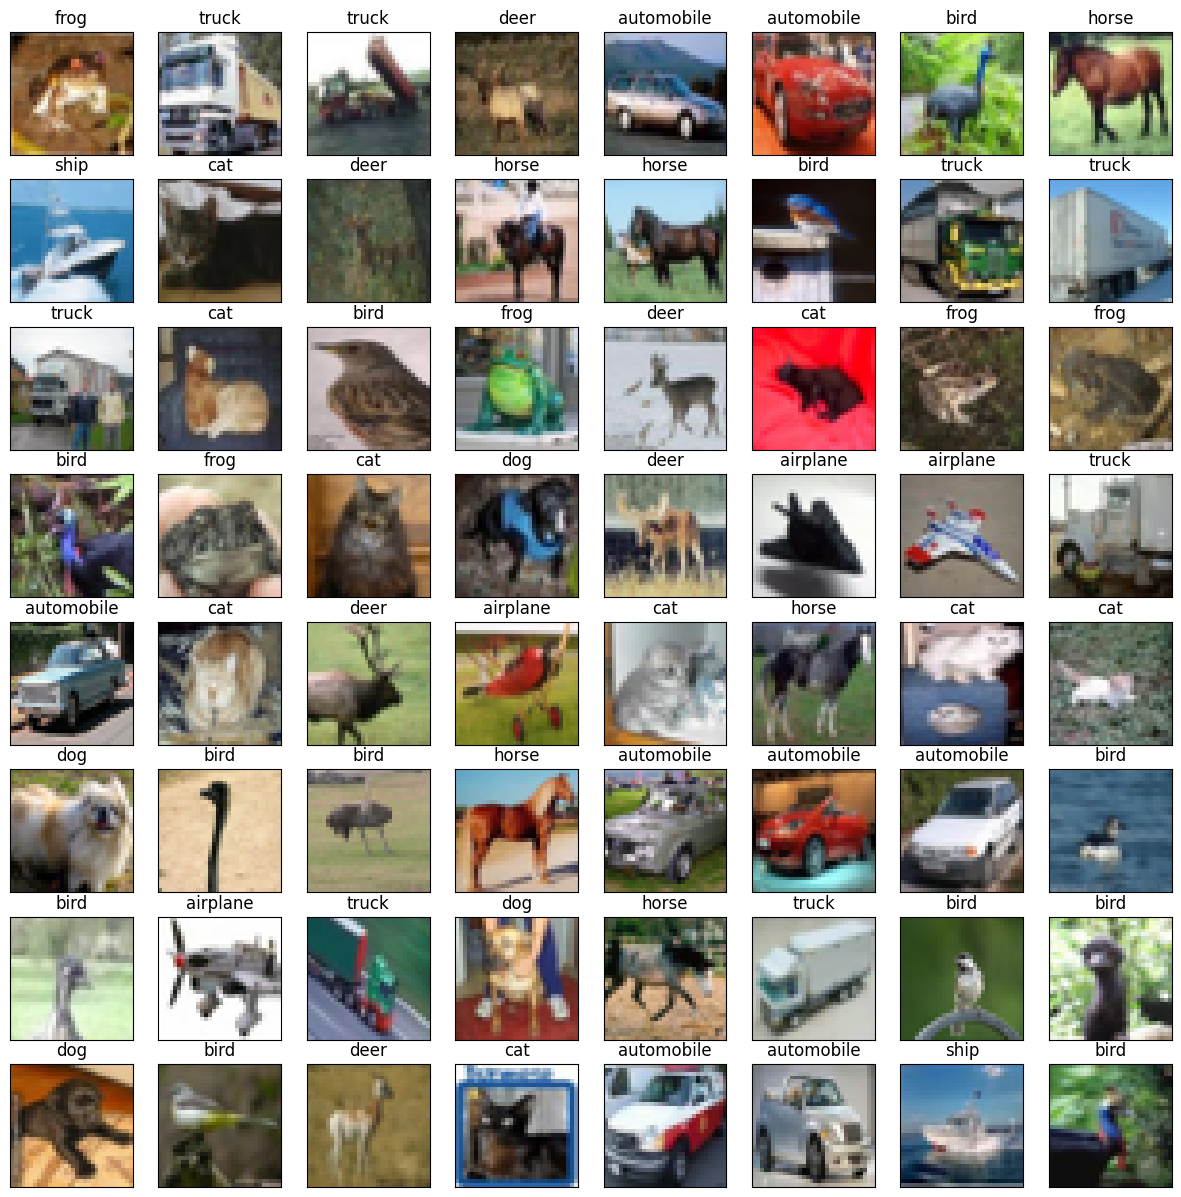

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(x_train_1[i])

    # Set the label as the title
    plt.title(class_names[y_train_1[i]], fontsize=12)

# Display the figure
plt.show()

(2500, 32, 32, 3) (2500,) (2500, 32, 32, 3) (2500,)


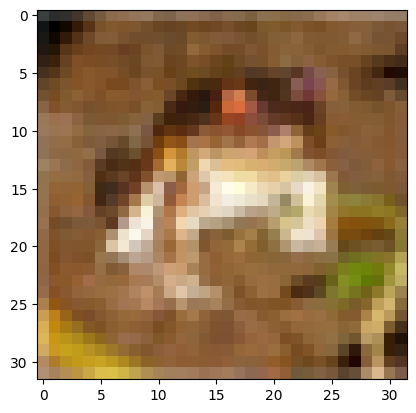

In [5]:
x_train_1 = np.array(x_train_1)
x_eval_1 = np.array(x_eval_1)
y_train_1 = np.array(y_train_1)
y_eval_1 = np.array(y_eval_1)

n_training = x_train_1.shape[0]
n_evaling = y_eval_1.shape[0]

y_train_1 = y_train_1.flatten()
y_eval_1  = y_eval_1.flatten()

print( x_train_1.shape, y_train_1.shape,  x_eval_1.shape, y_eval_1.shape )

from matplotlib import pyplot as plt
plt.imshow( x_train_1[0]  )
plt.show()

In [6]:
input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    return ResNet50(input_tensor=tf_input, include_top=False)

def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

In [7]:
batch_of_images_placeholder = tf.TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8)

batch_size = {
    'incv3'    : 16,
    'resnet50' : 8,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

tf_resize_op = lambda images: tf.image.resize(tf.cast(images, tf.float32), input_shape[:2])


In [8]:
preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

# Define generator
def data_generator(data, labels):
    def generator():
        n = data.shape[0]
        start = 0
        while start < n:
            end = min(start + batch_size, n)
            batch_of_images = data[start:end]
            batch_of_images_resized = tf_resize_op(batch_of_images)
            batch_of_images_preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            start += batch_size
            yield (batch_of_images_preprocessed, batch_of_labels)
    return generator

In [9]:
# Create model
model = create_model()

# Data generators
data_train_gen = data_generator(x_train_1, y_train_1)()
ftrs_training = model.predict(data_train_gen, steps=math.ceil(n_training/batch_size), verbose=1)

data_eval_gen = data_generator(x_eval_1, y_eval_1)()
ftrs_evaling = model.predict(data_eval_gen, steps=math.ceil(n_evaling/batch_size), verbose=1)


2024-11-12 13:31:14.639620: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/workspaces/CS771/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step


In [10]:
print(f"Expected number of training samples: {n_training}, Predicted features shape: {ftrs_training.shape}")
print(f"Expected number of evaluation samples: {n_evaling}, Predicted features shape: {ftrs_evaling.shape}")

Expected number of training samples: 2500, Predicted features shape: (2500, 1, 1, 2048)
Expected number of evaluation samples: 2500, Predicted features shape: (2500, 1, 1, 2048)


In [11]:
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_evaling  = np.array( [ftrs_evaling[i].flatten()  for i in range(n_evaling )] )

In [12]:
import numpy as np
import myutils

x_train_extracted_1 = features_training
y_train_1 = y_train_1

x_eval_extracted_1 = features_evaling
y_eval_1 = y_eval_1

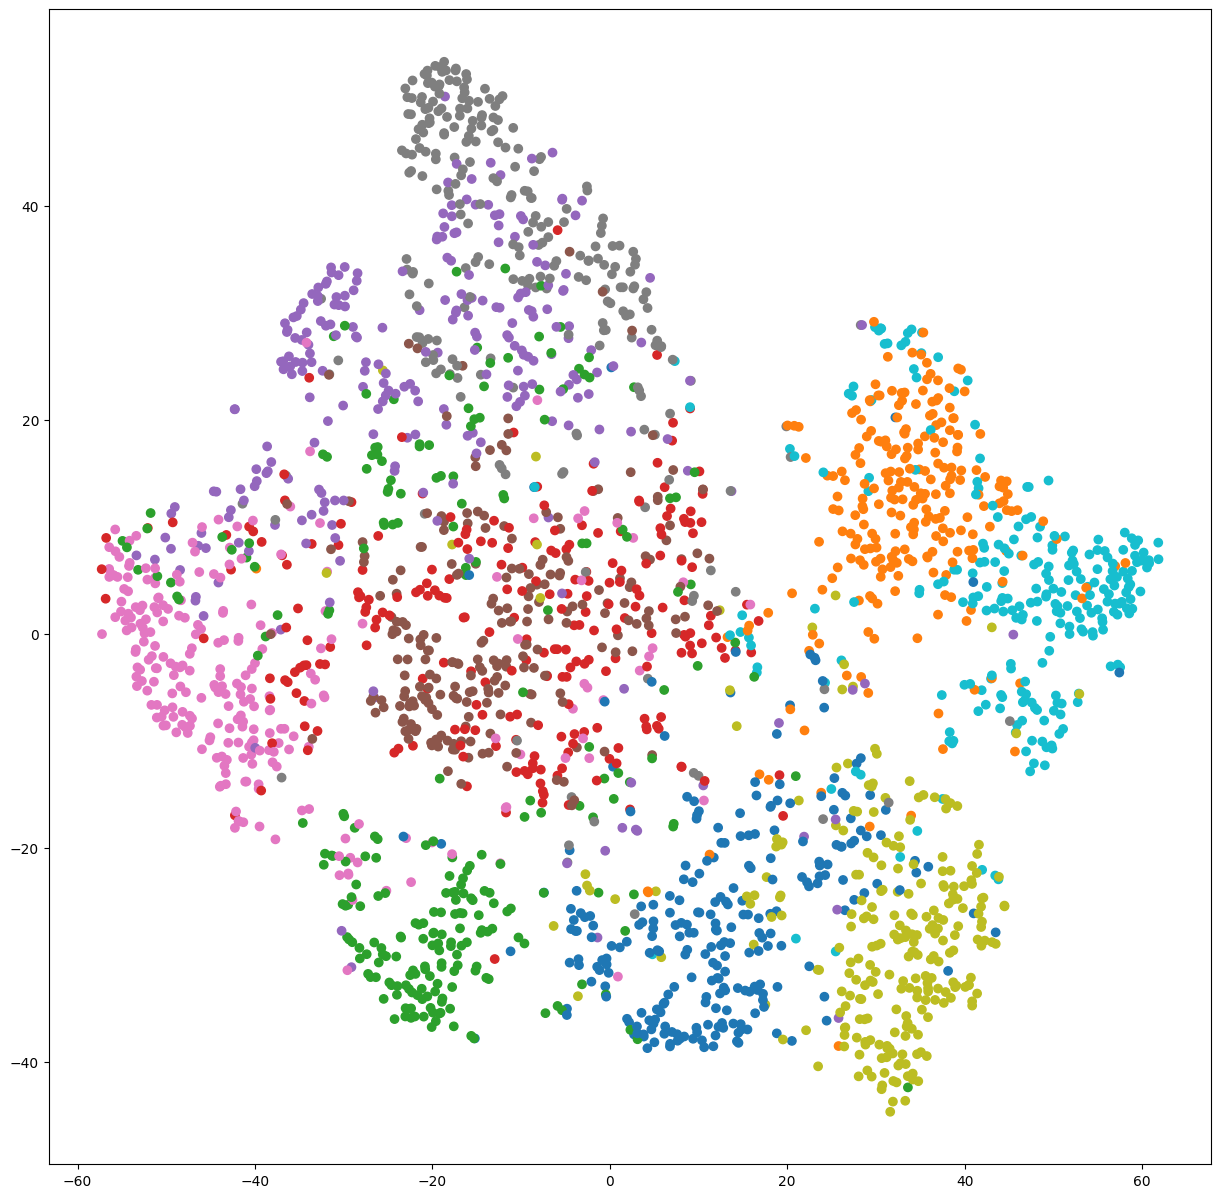

In [13]:
from sklearn import decomposition
from sklearn.manifold import TSNE
pca = decomposition.PCA(n_components=10)
X_training_reduced = pca.fit_transform(x_train_extracted_1)
tsne = TSNE(n_components=2)
X_training_reduced_tsne = tsne.fit_transform(X_training_reduced)
plt.figure( figsize=(15,15) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_train_1, cmap='tab10' )
plt.show()

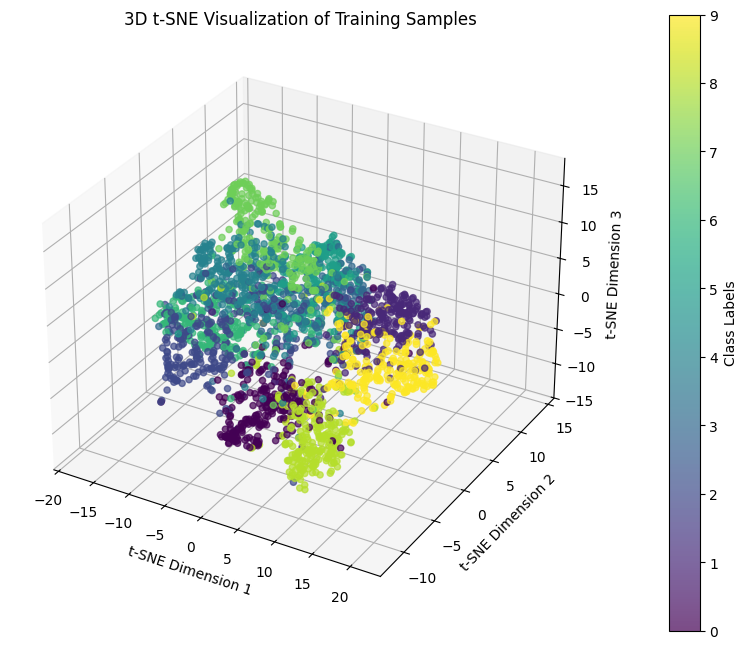

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Assuming data and labels are stored in x_train and y_train
# x_train.shape = (2500, 512) and y_train.shape = (2500,)

# Step 1: Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=3, random_state=42)
x_train_tsne = tsne.fit_transform(X_training_reduced)

# Step 2: Plot the data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Step 3: Scatter plot
scatter = ax.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], x_train_tsne[:, 2],
                     c=y_train_1, cmap='viridis', marker='o', alpha=0.7)

# Optional: Add color bar and labels
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Class Labels')
ax.set_title("3D t-SNE Visualization of Training Samples")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")

plt.show()

In [15]:
from sklearn.metrics import pairwise_distances

class LearningWithPrototypes:
    def __init__(self, n_classes, n_features):
        self.n_classes = n_classes
        self.n_features = n_features
        self.prototypes = np.zeros((n_classes, n_features))

    def fit(self, X_train, y_train):
        # Compute the prototypes for each class by averaging the feature vectors
        for c in range(self.n_classes):
            class_samples = X_train[y_train == c]
            if len(class_samples) > 0:
                self.prototypes[c] = np.mean(class_samples, axis=0)

    def predict(self, X):
        # Calculate the distance between each sample and each prototype
        distances = pairwise_distances(X, self.prototypes)

        # Assign each sample to the closest prototype
        predictions = np.argmin(distances, axis=1)
        return predictions

    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy


In [16]:
model = LearningWithPrototypes(n_classes=np.unique(y_train_1).size, n_features=x_train_extracted_1.shape[1])

# model = LearningWithPrototypes(n_classes=np.unique(y_train_1).size, n_features=x_train_extracted_1.shape[1], kernel="linear", gamma=0.5)

# Fit the model on the training data
model.fit(x_train_extracted_1, y_train_1)

# Evaluate on the evaluation set
accuracy = model.score(x_eval_extracted_1, y_eval_1)
print(f"Evaluation Accuracy: {accuracy * 100:.2f}%")

Evaluation Accuracy: 78.84%


In [17]:
from sklearn.metrics import pairwise_kernels
import numpy as np

class LearningWithPrototypes:
    def __init__(self, n_classes, n_features, kernel="rbf", **kernel_kwargs):
        self.n_classes = n_classes
        self.n_features = n_features
        self.kernel = kernel
        self.kernel_kwargs = kernel_kwargs
        self.prototypes = None
        self.X_train = None  # Store the training data for consistent kernel calculations

    def fit(self, X_train, y_train):
        self.X_train = X_train  # Reference set for kernel calculations
        self.prototypes = []

        for c in range(self.n_classes):
            class_samples = X_train[y_train == c]
            if len(class_samples) > 0:
                # Compute prototype relative to all training samples
                prototype = np.mean(pairwise_kernels(class_samples, X_train, metric=self.kernel, **self.kernel_kwargs), axis=0)
                self.prototypes.append(prototype)

        self.prototypes = np.array(self.prototypes)

    def predict(self, X):
        # Calculate kernel distances between samples in X and the prototypes
        kernel_distances = pairwise_kernels(X, self.prototypes, metric=self.kernel, **self.kernel_kwargs)
        predictions = np.argmin(kernel_distances, axis=1)
        return predictions

    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

# Example usage with RBF kernel
model = LearningWithPrototypes(n_classes=np.unique(y_train_1).size, n_features=x_train_extracted_1.shape[1], kernel="rbf", gamma=0.5)
model.fit(x_train_extracted_1, y_train_1)
accuracy = model.score(x_eval_extracted_1, y_eval_1)
print(f"Evaluation Accuracy: {accuracy * 100:.2f}%")


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 2048 while Y.shape[1] == 2500